$$
\text{Admittance System}
$$

Steps:
1. Make the plant easier to control first (passive design)
2. Then design the controller for the optimized plant

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import control

def analyze_plant_controllability(m, k, c):
    """
    Analyze how plant parameters affect controllability
    """
    # Natural frequency and damping
    wn = np.sqrt(k/m)
    zeta = c/(2*np.sqrt(k*m))
    
    # Time constant (how fast the system responds naturally)
    if zeta >= 1:
        # Overdamped
        tau = 1/(zeta*wn)
    else:
        # Underdamped
        tau = 1/(zeta*wn)
    
    # Control authority metric (how much force needed per unit acceleration)
    control_authority = m
    
    # Resonance peak (amplification at natural frequency)
    if zeta < 0.707:
        resonance_peak = 1/(2*zeta*np.sqrt(1-zeta**2))
    else:
        resonance_peak = 1
    
    return {
        'wn': wn,
        'zeta': zeta,
        'tau': tau,
        'control_authority': control_authority,
        'resonance_peak': resonance_peak
    }

# Example analysis
params = analyze_plant_controllability(m=1.0, k=10.0, c=2.0)
print("Plant Analysis:")
for key, value in params.items():
    print(f"  {key}: {value:.3f}")

def optimize_plant_parameters(constraints, objectives):
    """
    Find optimal m, k, c values for best controllability
    
    constraints: dict with min/max values for m, k, c
    objectives: dict with desired specifications
    """
    
    def cost_function(x):
        m, k, c = x
        
        # Natural frequency and damping
        wn = np.sqrt(k/m)
        zeta = c/(2*np.sqrt(k*m))
        
        # Penalize deviation from ideal damping (0.7 is often good)
        damping_cost = (zeta - 0.7)**2
        
        # Penalize high mass (harder to control)
        mass_cost = m / constraints['m_max']
        
        # Penalize very high or very low natural frequency
        wn_ideal = objectives.get('wn_ideal', 5.0)
        frequency_cost = ((wn - wn_ideal) / wn_ideal)**2
        
        # Penalize high spring constant (cost/stress)
        spring_cost = k / constraints['k_max']
        
        # Total weighted cost
        weights = objectives.get('weights', {
            'damping': 1.0,
            'mass': 0.5,
            'frequency': 0.3,
            'spring': 0.2
        })
        
        total_cost = (weights['damping'] * damping_cost +
                     weights['mass'] * mass_cost +
                     weights['frequency'] * frequency_cost +
                     weights['spring'] * spring_cost)
        
        return total_cost
    
    # Initial guess
    x0 = [constraints['m_max']/2, 
          constraints['k_max']/2, 
          constraints['c_max']/2]
    
    # Bounds
    bounds = [(constraints['m_min'], constraints['m_max']),
              (constraints['k_min'], constraints['k_max']),
              (constraints['c_min'], constraints['c_max'])]
    
    # Optimize
    result = minimize(cost_function, x0, bounds=bounds, method='L-BFGS-B')
    
    return result.x

# Example optimization
constraints = {
    'm_min': 0.1, 'm_max': 10.0,  # kg
    'k_min': 1.0, 'k_max': 100.0,  # N/m
    'c_min': 0.1, 'c_max': 20.0   # N·s/m
}

objectives = {
    'wn_ideal': 5.0,  # Desired natural frequency
    'weights': {
        'damping': 2.0,    # Most important
        'mass': 1.0,       # Important
        'frequency': 0.5,  # Less important
        'spring': 0.3      # Least important
    }
}

m_opt, k_opt, c_opt = optimize_plant_parameters(constraints, objectives)
print(f"\nOptimized plant: m={m_opt:.3f}, k={k_opt:.3f}, c={c_opt:.3f}")

Plant Analysis:
  wn: 3.162
  zeta: 0.316
  tau: 1.000
  control_authority: 1.000
  resonance_peak: 1.667

Optimized plant: m=0.185, k=3.944, c=1.183


/home/col/.local/lib/python3.12/site-packages/control/pzmap.py:327: FutureWarning: pole_zero_plot() return value of poles, zeros is deprecated; use pole_zero_map()
  warnings.warn(


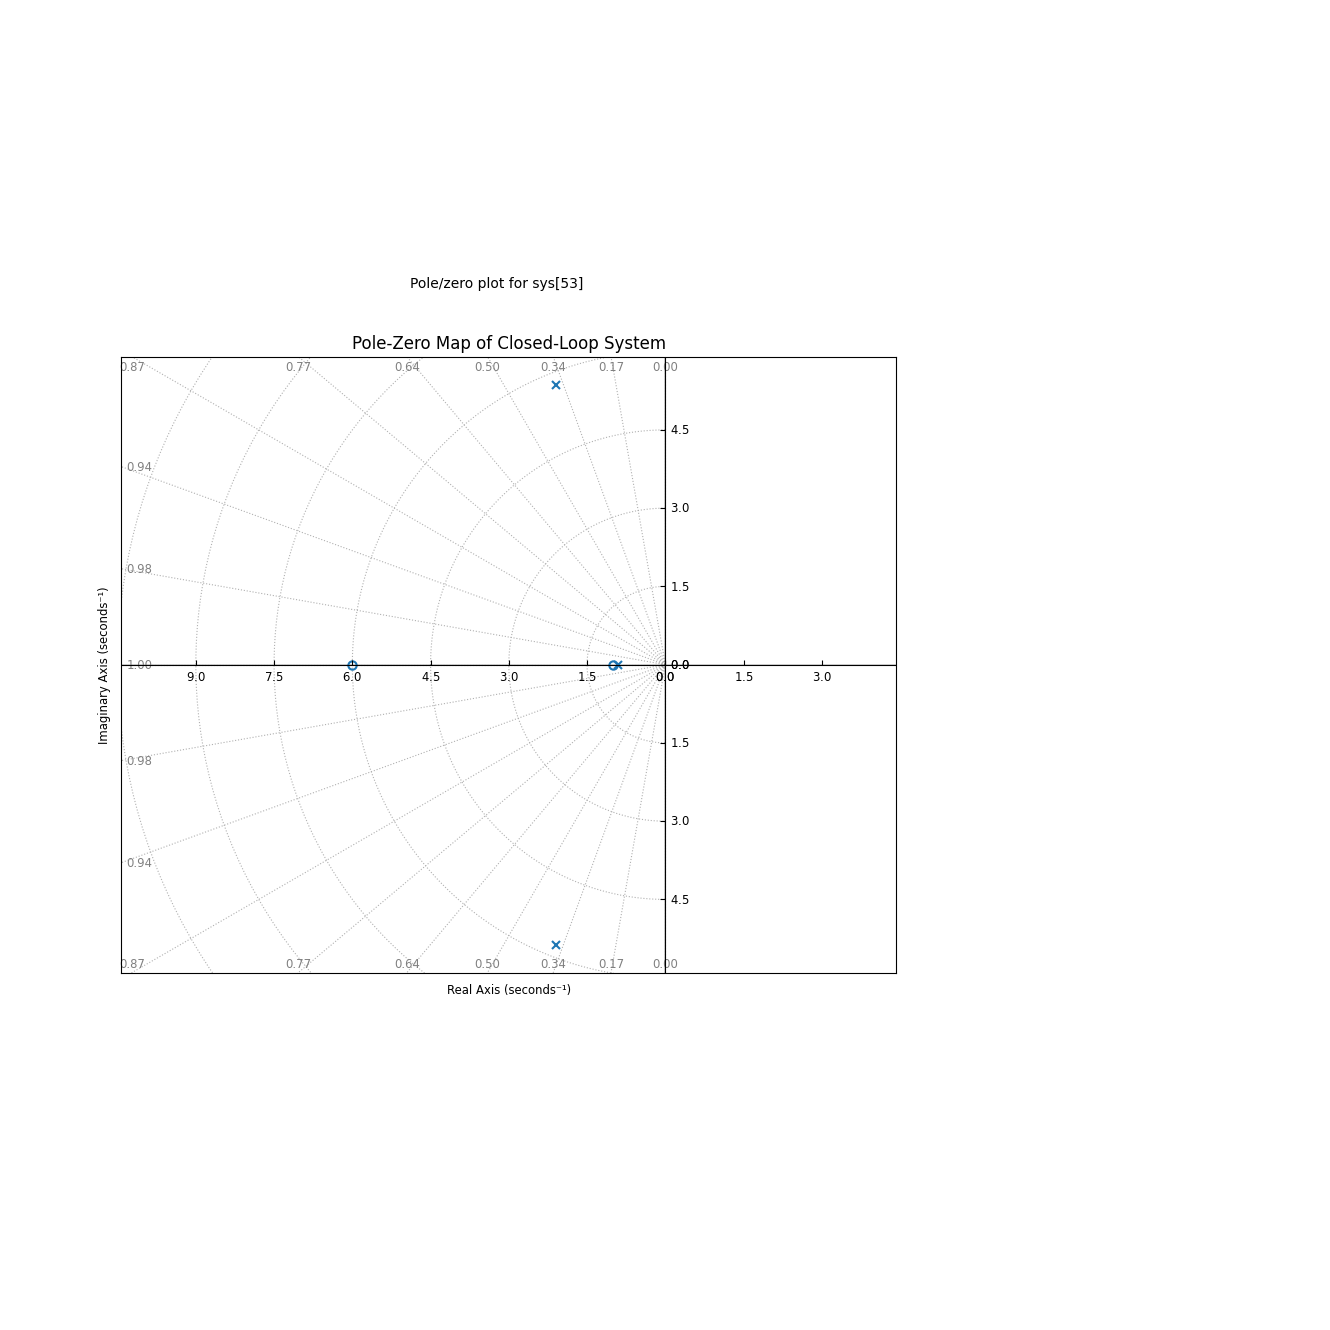

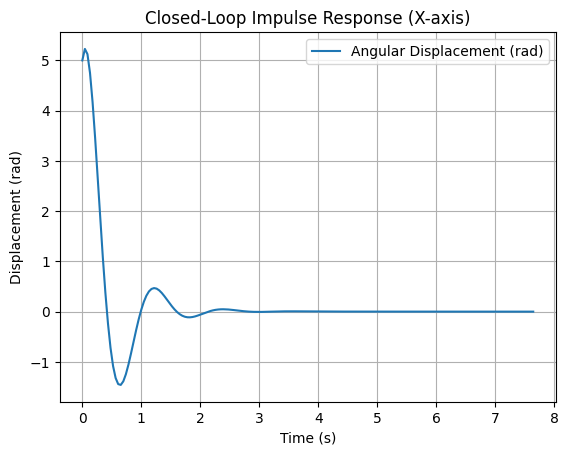

In [ ]:
I = 10.0  # Moment of inertia (kg·m²)
k = 20.0  # spring constant (N/m)
c = 1.0  # damping coefficient (N·s/m)
I = m_opt
k = k_opt
c = c_opt
Kp = 350.0  # Proportional gain
Ki = 300.0  # Integral gain
Kd = 50.0   # Derivative gain

# Natural Frequency and Damping Ratio
wn = (k/I)**0.5  # Natural frequency (rad/s)
zeta = c/(2*wn*I)  # Damping ratio

# Calculate PID gains for well-damped response


# Plant transfer function: G(s) = 1/(Is² + cs + k)
G = control.TransferFunction([1], [I, c, k])

# PID controller: C(s) = Kp + Ki/s + Kd*s
C = control.TransferFunction([Kd, Kp, Ki], [1, 0])

# Closed-loop transfer function: T(s) = GC/(1 + GC)
T = control.feedback(G * C)

# Poles and Zeros
plt.figure(figsize=(10, 8))
poles, zeros = control.pzmap(T, plot=True, grid=True)
plt.title('Pole-Zero Map of Closed-Loop System')
plt.xlabel('Real Axis (seconds⁻¹)')
plt.ylabel('Imaginary Axis (seconds⁻¹)')
plt.show()

# Simulate impulse response
t, y = control.impulse_response(T)

# figure for x-axis response
plt.figure()
plt.plot(t, y, label='Angular Displacement (rad)')
plt.title('Closed-Loop Impulse Response (X-axis)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (rad)')
plt.grid()
plt.legend()
plt.show()

In [13]:
import numpy as np
import control
import matplotlib.pyplot as plt

def place_poles_from_specs(ts_desired, Mp_percent, criterion='2%'):
    """
    Calculate pole locations from desired specifications
    
    Parameters:
    ts_desired: desired settling time [s]
    Mp_percent: desired maximum overshoot [%]
    criterion: '2%' or '5%' settling time criterion
    """
    
    # Calculate damping ratio from overshoot
    if Mp_percent == 0:
        zeta = 1.0  # Critically damped
    else:
        Mp = Mp_percent / 100
        zeta = np.sqrt(np.log(Mp)**2 / (np.pi**2 + np.log(Mp)**2))
    
    # Calculate natural frequency from settling time
    if criterion == '2%':
        wn = 4 / (zeta * ts_desired)
    else:  # 5% criterion
        wn = 3 / (zeta * ts_desired)
    
    # Calculate pole locations
    sigma = -zeta * wn  # Real part
    wd = wn * np.sqrt(1 - zeta**2)  # Imaginary part (damped frequency)
    
    # Dominant poles (complex conjugate pair)
    pole1 = sigma + 1j * wd
    pole2 = sigma - 1j * wd
    
    return pole1, pole2, zeta, wn

# Example: Design for specific requirements
ts_desired = 1.0   # 1 second settling time
Mp_desired = 10    # 10% overshoot

# Get dominant pole locations
p1, p2, zeta, wn = place_poles_from_specs(ts_desired, Mp_desired)

print(f"Desired Specifications:")
print(f"  Settling time: {ts_desired} s")
print(f"  Overshoot: {Mp_desired}%")
print(f"\nCalculated Parameters:")
print(f"  Damping ratio ζ: {zeta:.3f}")
print(f"  Natural frequency ωn: {wn:.3f} rad/s")
print(f"  Dominant poles: {p1:.3f}, {p2:.3f}")

Desired Specifications:
  Settling time: 1.0 s
  Overshoot: 10%

Calculated Parameters:
  Damping ratio ζ: 0.591
  Natural frequency ωn: 6.766 rad/s
  Dominant poles: -4.000+5.458j, -4.000-5.458j


In [14]:
def design_pid_from_specs(m, k, c, ts_desired, Mp_percent, third_pole_factor=5):
    """
    Design PID controller from desired specifications
    
    Parameters:
    m, k, c: plant parameters
    ts_desired: desired settling time
    Mp_percent: desired overshoot percentage
    third_pole_factor: how much farther left to place the third pole
    """
    
    # Get dominant poles from specifications
    p1, p2, zeta, wn = place_poles_from_specs(ts_desired, Mp_percent)
    
    # Place third pole (from integral action)
    # Should be far enough left not to affect transient response
    p3 = third_pole_factor * p1.real  # 5-10x farther left
    
    # All three closed-loop poles
    desired_poles = [p1, p2, p3]
    
    # Form desired characteristic polynomial
    # (s-p1)(s-p2)(s-p3) = s³ + a₂s² + a₁s + a₀
    poly_coeffs = np.poly(desired_poles)
    a2 = poly_coeffs[1].real
    a1 = poly_coeffs[2].real
    a0 = poly_coeffs[3].real
    
    # Match with closed-loop characteristic equation
    # ms³ + (c+Kd)s² + (k+Kp)s + Ki = ms³ + ma₂s² + ma₁s + ma₀
    
    Kd = m * a2 - c
    Kp = m * a1 - k
    Ki = m * a0
    
    return Kp, Ki, Kd, desired_poles

# System parameters
m, k, c = 1.0, 10.0, 2.0

# Design controller
Kp, Ki, Kd, poles = design_pid_from_specs(m, k, c, 
                                          ts_desired=1.0, 
                                          Mp_percent=10)

print(f"\nPID Gains:")
print(f"  Kp = {Kp:.3f}")
print(f"  Ki = {Ki:.3f}")
print(f"  Kd = {Kd:.3f}")


PID Gains:
  Kp = 195.784
  Ki = 915.687
  Kd = 26.000


/tmp/ipykernel_17773/3445324480.py:83: RuntimeWarning: divide by zero encountered in divide
  Mp_range = np.exp(-np.pi * zeta_range / np.sqrt(1 - zeta_range**2)) * 100


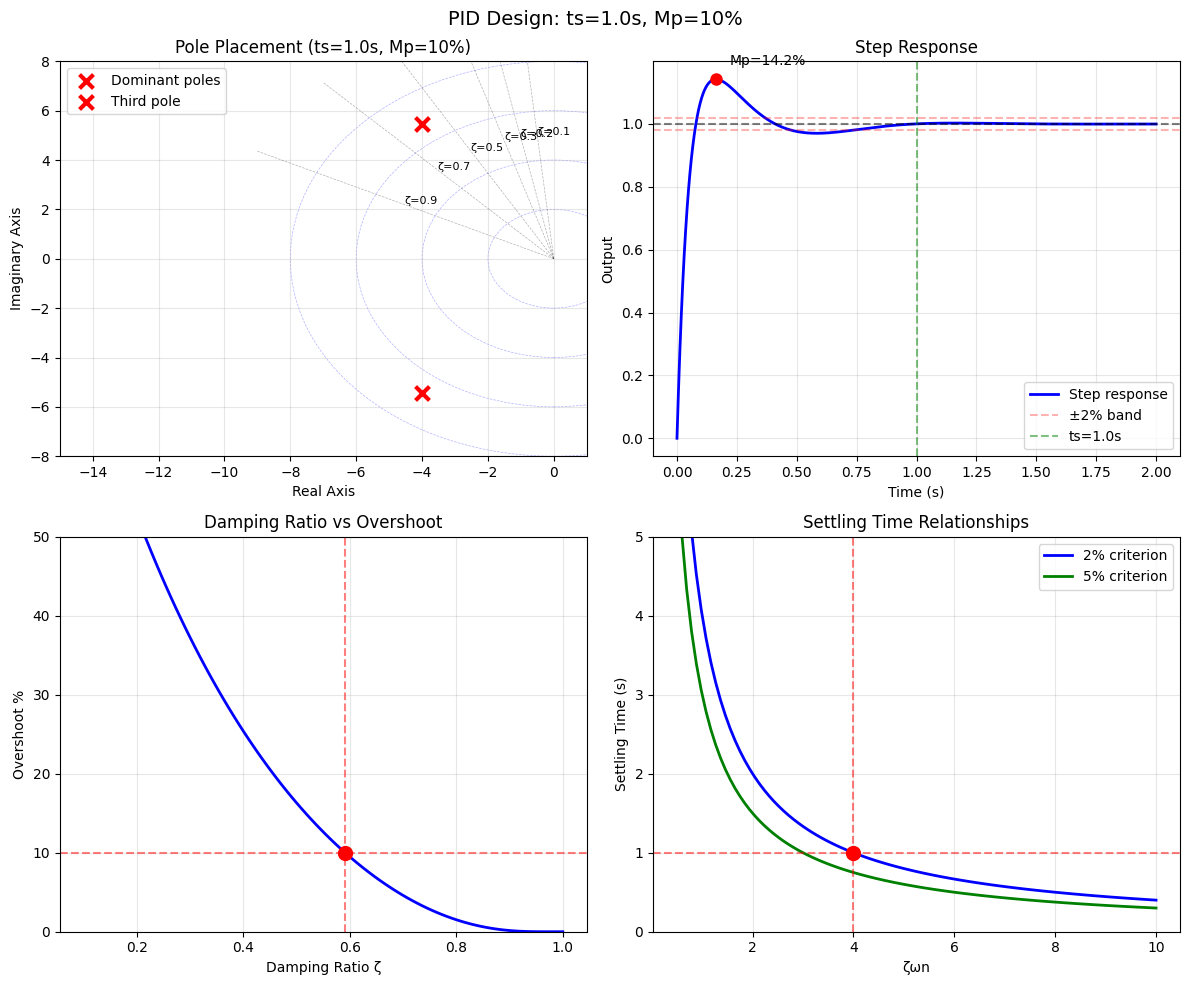


Actual Performance:
  Settling time: 0.736 s
  Overshoot: 14.2%
  Rise time: 0.055 s


In [15]:
def visualize_pole_placement(m, k, c, ts_desired, Mp_percent):
    """
    Visualize how specifications map to pole locations and response
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Design specifications to pole locations
    ax1 = axes[0, 0]
    
    # Show constant damping ratio lines
    zeta_values = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
    theta_values = np.linspace(0, np.pi, 100)
    
    for zeta in zeta_values:
        angle = np.arccos(zeta)
        r = np.linspace(0, 10, 100)
        x = -r * np.cos(angle)
        y = r * np.sin(angle)
        ax1.plot(x, y, 'k--', alpha=0.3, linewidth=0.5)
        ax1.text(x[50], y[50], f'ζ={zeta}', fontsize=8)
    
    # Show constant natural frequency circles
    for wn in [2, 4, 6, 8]:
        circle = plt.Circle((0, 0), wn, fill=False, linestyle='--', 
                          color='blue', alpha=0.3, linewidth=0.5)
        ax1.add_patch(circle)
    
    # Plot desired poles
    p1, p2, zeta, wn = place_poles_from_specs(ts_desired, Mp_percent)
    p3 = 5 * p1.real
    
    ax1.scatter([p1.real, p2.real], [p1.imag, p2.imag], 
               color='red', s=100, marker='x', linewidth=3, 
               label='Dominant poles', zorder=5)
    ax1.scatter([p3], [0], color='red', s=100, marker='x', 
               linewidth=3, label='Third pole', zorder=5)
    
    ax1.set_xlabel('Real Axis')
    ax1.set_ylabel('Imaginary Axis')
    ax1.set_title(f'Pole Placement (ts={ts_desired}s, Mp={Mp_percent}%)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xlim(-15, 1)
    ax1.set_ylim(-8, 8)
    
    # 2. Step response
    ax2 = axes[0, 1]
    
    Kp, Ki, Kd, _ = design_pid_from_specs(m, k, c, ts_desired, Mp_percent)
    
    # Create closed-loop system
    G = control.TransferFunction([1], [m, c, k])
    C = control.TransferFunction([Kd, Kp, Ki], [1, 0])
    T = control.feedback(G * C)
    
    t, y = control.step_response(T, T=np.linspace(0, 2*ts_desired, 1000))
    
    ax2.plot(t, y, 'b-', linewidth=2, label='Step response')
    ax2.axhline(y=1.0, color='k', linestyle='--', alpha=0.5)
    ax2.axhline(y=1.02, color='r', linestyle='--', alpha=0.3, label='±2% band')
    ax2.axhline(y=0.98, color='r', linestyle='--', alpha=0.3)
    ax2.axvline(x=ts_desired, color='g', linestyle='--', alpha=0.5, 
               label=f'ts={ts_desired}s')
    
    # Mark overshoot
    peak_idx = np.argmax(y)
    ax2.plot(t[peak_idx], y[peak_idx], 'ro', markersize=8)
    ax2.annotate(f'Mp={((y[peak_idx]-1)*100):.1f}%', 
                xy=(t[peak_idx], y[peak_idx]), 
                xytext=(10, 10), textcoords='offset points')
    
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Output')
    ax2.set_title('Step Response')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. Relationship between ζ and Mp
    ax3 = axes[1, 0]
    
    zeta_range = np.linspace(0.1, 1.0, 100)
    Mp_range = np.exp(-np.pi * zeta_range / np.sqrt(1 - zeta_range**2)) * 100
    
    ax3.plot(zeta_range, Mp_range, 'b-', linewidth=2)
    ax3.axvline(x=zeta, color='r', linestyle='--', alpha=0.5)
    ax3.axhline(y=Mp_percent, color='r', linestyle='--', alpha=0.5)
    ax3.scatter([zeta], [Mp_percent], color='red', s=100, zorder=5)
    
    ax3.set_xlabel('Damping Ratio ζ')
    ax3.set_ylabel('Overshoot %')
    ax3.set_title('Damping Ratio vs Overshoot')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 50)
    
    # 4. Relationship between ζωn and settling time
    ax4 = axes[1, 1]
    
    zeta_wn_range = np.linspace(0.5, 10, 100)
    ts_2percent = 4 / zeta_wn_range
    ts_5percent = 3 / zeta_wn_range
    
    ax4.plot(zeta_wn_range, ts_2percent, 'b-', linewidth=2, label='2% criterion')
    ax4.plot(zeta_wn_range, ts_5percent, 'g-', linewidth=2, label='5% criterion')
    
    zeta_wn_actual = zeta * wn
    ax4.axvline(x=zeta_wn_actual, color='r', linestyle='--', alpha=0.5)
    ax4.axhline(y=ts_desired, color='r', linestyle='--', alpha=0.5)
    ax4.scatter([zeta_wn_actual], [ts_desired], color='red', s=100, zorder=5)
    
    ax4.set_xlabel('ζωn')
    ax4.set_ylabel('Settling Time (s)')
    ax4.set_title('Settling Time Relationships')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    ax4.set_ylim(0, 5)
    
    plt.suptitle(f'PID Design: ts={ts_desired}s, Mp={Mp_percent}%', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return T

# Visualize the design
T = visualize_pole_placement(m, k, c, ts_desired=1.0, Mp_percent=10)

# Print performance summary
info = control.step_info(T)
print(f"\nActual Performance:")
print(f"  Settling time: {info['SettlingTime']:.3f} s")
print(f"  Overshoot: {info['Overshoot']:.1f}%")
print(f"  Rise time: {info['RiseTime']:.3f} s")

In [ ]:
T = visualize_pole_placement(m, k, c, ts_desired=1.0, Mp_percent=10)